In [142]:
from librosa.effects import pitch_shift
import os
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, SeparableConv1D, MaxPooling1D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

features = []
labels = []
dataset_path: str = "C:\\Users\\rclendening\\researchData\\RedVox_TrainingBinary1"
data_dir = pathlib.Path(dataset_path)
droneDict = {  # One hot encoding for labels probs should do it like I did below?
    "Drone": [1, 0],
    "Noise": [0, 1]
}
droneCountDict = {  # One hot encoding for labels
    "Drone": 0,
    "Noise": 1
}

dataCount = [0, 0]
drones = np.array(tf.io.gfile.listdir(str(data_dir)))
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
train_files = filenames
# x = round((len(train_files) / 5))
# train_files = train_files[:x]
print("Total num of samples: ", num_samples)
print("Number of examples per label:", len(tf.io.gfile.listdir(str(data_dir / drones[0]))))
print("Example file tensor: ", filenames[0])
print(drones)

# test_file = tf.io.read_file(
#     "C:\\Users\\rclendening\\researchData\\Training_Data_NM_RS\\IF1200\\d301sA1r01p0120210823_6.wav")
# test_audio, _ = tf.audio.decode_wav(contents=test_file)
# test_audio.shape


def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)


def get_label(file_path):
    parts = tf.strings.split(input=file_path, sep=os.path.sep)
    return parts[-2]


def split_audio(waveData, labelName, sampleFreq):
    '''
    Frames audio data and converts to feature space (spectrogram)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    # middle third of data
    duration = waveData.shape[0]
    startTime = np.round(duration / 3)
    endTime = np.round(duration * 2 / 3)
    waveDataSplit= waveData[int(startTime):int(endTime)]
    features=mfcc(waveDataSplit.numpy().squeeze(), sampleFreq)
    dataCount[droneCountDict[labelName]] += features.shape[1]
    label= [droneDict[labelName]] * features.shape[1]
    return features, label

def create_dataset(train_files):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    i = 0
    features = []
    labels = []
    for x in train_files:
        test_file = tf.io.read_file(x)
        test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        if sampleRate != 8000:
            break;
        x = str(x)
        label = x.split('\\')
        label = label[10]
        newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % 8000]  # trim to nearest second
        newFeats, newLabs = split_audio(newData, label, int(sampleRate))
        features.extend(newFeats.transpose())
        labels.extend(newLabs)

    return features, labels


def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

def MFCCCalc(audioData, sampleRate):
    audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(data, hop_length=2048)

    return coefs

def grabTrainingSamples(n, trainingData):
    droneCount=0
    noiseCount=0
    evenTrainingData = []
    evenLabelData = []
    for i in range(len(labels)):
        lab = trainingData[i][1]
        if lab == [1, 0] and droneCount < n:
            droneCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(lab)
        elif lab == [0,1] and noiseCount < n:
            noiseCount += 1
            evenTrainingData.append(trainingData[i][0])
            evenLabelData.append(lab)
    return evenTrainingData, evenLabelData

Fs = 8000
numFeat = 20 #COULD BE SOURCE OF ERROR
features, labels = create_dataset(train_files)
newSet = list(zip(features, labels))
random.seed()
random.shuffle(newSet)  # Ensure data is mixed together
n = np.min(dataCount)  # Ensure data is symmetric (aka even amounts of training data for all classes)
# features, labels = grabTrainingSamples(n, features, labels)
features, labels = grabTrainingSamples(n, newSet)

trainFeatures, testFeatures, trainTargets, testTargets = train_test_split(features, labels, test_size=0.2,                                                                  random_state=25)
# Standardize features
trainFeatures = np.asarray(trainFeatures)
trainTargets = np.asarray(trainTargets)
mean = trainFeatures.mean(axis=0)
trainFeatures -= mean
std = trainFeatures.std(axis=0)
trainFeatures /= std
trainFeatures = np.reshape(trainFeatures,
                           (len(trainFeatures), numFeat, 1))
testFeatures = np.asarray(testFeatures)
testTargets = np.asarray(testTargets)
testFeatures -= mean
testFeatures /= std
testFeatures = np.reshape(testFeatures, (len(testFeatures), numFeat, 1))



Total num of samples:  1215
Number of examples per label: 1036
Example file tensor:  tf.Tensor(b'C:\\Users\\rclendening\\researchData\\RedVox_TrainingBinary1\\Noise\\A72R0P1Phone_3-5.wav', shape=(), dtype=string)
['Drone' 'Noise']


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_14240\2560009325.py:78: FutureWarning: Pass y=[0.00546265 0.00549316 0.00521851 ... 0.0088501  0.01022339 0.0093689 ], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features=mfcc(waveDataSplit.numpy().squeeze(), sampleFreq)
C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_14240\2560009325.py:78: FutureWarning: Pass y=[-0.06201172 -0.06332397 -0.06469727 ...  0.04345703  0.04403687
  0.0446167 ], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features=mfcc(waveDataSplit.numpy().squeeze(), sampleFreq)
C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_14240\2560009325.py:78: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features=mfcc(waveDataSplit.numpy().squeeze(), sampleFreq)
C:\Users\rclendening\AppData\L

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 conv_1 (Conv1D)             (None, 9, 32)             96        
                                                                 
 batch_normalization_3 (Batc  (None, 9, 32)            128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 9, 32)             0         
                                                                 
 conv_2 (Conv1D)             (None, 4, 32)             3072      
                                                                 
 batch_normalization_4 (Batc  (None, 4, 32)            128       
 hNormalization)                                           

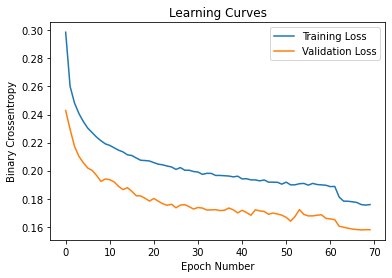

In [143]:
# Probabilistic range regression network
# def NLL(y, distr):  #Loss function
#    return -distr.log_prob(y)
# def normal_sp(params):  #Distribution function
#    return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:, 1:2]))  # Both mean and variance parameters are learnable
# inputs = Input(shape=(numFeat, 1))
# hidden = BatchNormalization()(inputs)
# hidden = Conv1D(64, 12, strides=2, use_bias=False, name='conv_1')(hidden)
# hidden = Conv1D(128, 12, strides=2, use_bias=False, name='conv_2')(hidden)
# #hidden = MaxPooling1D()(hidden)
# hidden = Dropout(0.25)(hidden)
# hidden = Flatten()(hidden)
# hidden = Dropout(0.1)(hidden)
# hidden = Flatten()(hidden)
# dist = Dense(5, activation='softmax', name='dense_2')(hidden)
inputs = Input(shape=(numFeat, 1))
hidden = Conv1D(filters=32,kernel_size=3, strides=2, use_bias=False, name='conv_1')(inputs)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = Conv1D(filters=32,kernel_size=3, strides=2, use_bias=False,
                         name='conv_2')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = Conv1D(filters=32, kernel_size=3, strides=2, use_bias=False,
                         name='conv_3')(hidden)
hidden = BatchNormalization()(hidden)
hidden = Activation('relu')(hidden)
# hidden = MaxPooling1D(3, strides=2)(hidden)
hidden = Flatten()(hidden)
hidden = Dropout(0.1)(hidden)
hidden = Dense(864, activation='relu', name='dense_1')(hidden)  # 896, 864, 928
hidden = Dropout(0.1)(hidden)
dist = Dense(len(dataCount), activation='sigmoid', name='dense_2')(hidden)
network = Model(inputs=inputs, outputs=dist)
network.summary()
network.compile(optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],)
# Train classifier
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto')
history = network.fit(trainFeatures, trainTargets,
                      epochs=70,
                      batch_size=32,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()
# if retrain:
#     call2 = ModelCheckpoint(filepath=(dirWeights + weights_save),
#                             verbose=1, monitor='val_loss', save_best_only=True)
#     reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                                  verbose=1, patience=10, mode='auto')
#     early = EarlyStopping(monitor='val_loss', min_delta=1e-4,
#                           patience=40, mode='auto')
#     history = network.fit(trainFeatures, trainTargets,
#                           epochs=1000,
#                           batch_size=32,
#                           shuffle=True,
#                           validation_split=0.2,
#                           callbacks=[reduceLR, early, call2])
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Learning Curves')
#     plt.legend(['Training Loss', 'Validation Loss'])
#     plt.ylabel('Binary Crossentropy')
#     plt.xlabel('Epoch Number')
#     plt.show()
#     network.load_weights(dirWeights + weights_load, by_name=True)
# else:
#     network.load_weights(dirWeights + weights_load, by_name=True)

In [144]:
y_pred = np.argmax(network.predict(testFeatures), axis=1)
y_predict=[]
for x in y_pred:
    ans=np.zeros(2)
    ans[x]=1
    y_predict.append(ans)
y_true = testTargets
Sum=0
for x in range(len(y_predict)):
    if np.array_equiv(y_predict[x].tolist(),y_true[x]):
        Sum+=1
#Sum=sum(y_predict == y_true)
#list=[IF,Matrice,Mavic,Noise,Phantom]
#print(np.max(list))
test_acc = Sum/ len(y_true)
print(f'Test set accuracy:', test_acc)

Test set accuracy: 0.9297185926108548


Testing with cell phone scenario. Achieving 0% accuracy because although sampled at same frequency, there must be some cell phone artifacts in the noise data that is making all cell phone data be seen as noise. After further evaluation, taking the logPSD causes the training data to potentially overfit(?). When PSD is calculated without log, the algorithm can accurately predict the drone when using cell phones as test data. Further investigation will be required to further refine and determine.

This function implements majority voting scheme. It assumes all cell phones record an equal amount of data during a test, and assumes the class with the most votes is the correct class.

C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_14240\1938371809.py:12: FutureWarning: Pass y=[-0.0814209  -0.07913208 -0.07183838 ...  0.16567993  0.02984619
 -0.01596069], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features=mfcc(waveData.numpy().squeeze(), sampleFreq)
C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_14240\1938371809.py:12: FutureWarning: Pass y=[ 0.2696228   0.27789307  0.29281616 ... -0.1800232  -0.17337036
 -0.16281128], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features=mfcc(waveData.numpy().squeeze(), sampleFreq)
C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_14240\1938371809.py:12: FutureWarning: Pass y=[ 0.04641724  0.00082397 -0.04458618 ... -0.09213257 -0.07278442
 -0.04815674], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  features=mfcc(waveData.numpy().squeez


Single Phone 0.2575
Single Phone 0.1225
Single Phone 0.175
Single Phone 1.0025
Single Phone 1.0
Single Phone 0.4675
Single Phone 0.975
Single Phone 0.95
Single Phone 1.0025
Single Phone 1.0025
Single Phone 0.9975
Single Phone 0.52
Single Phone 1.0025
Single Phone 1.0025
Single Phone 0.7225
Single Phone 1.0025
Single Phone 1.0025
Single Phone 0.995
Single Phone 0.965
Single Phone 0.8425
Single Phone 0.13
Single Phone 0.9325
Single Phone 0.8275
Single Phone 1.0
Single Phone 1.0025
Single Phone 1.0025
Accuracy for drone present: 1.0


<Figure size 432x288 with 0 Axes>

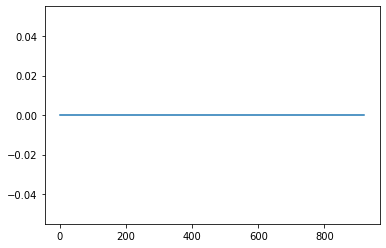

<Figure size 432x288 with 0 Axes>

In [188]:
def split_test_audio(waveData, labelName, sampleFreq):
    '''
    Frames audio data and converts to feature space (spectrogram)
    :param waveData: waveData array of time-domain audio
    :param frame_duration: Duration of frames desired
    :param startTime: Start for each clip
    :param sampleFreq: Sample Frequency (8Khz)
    :param labelName: Name of label
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    duration = waveData.shape[0]
    features=mfcc(waveData.numpy().squeeze(), sampleFreq)
    label= [droneDict[labelName]] * features.shape[1]
    return features, label

def create_test_dataset(test_files, testTime):
    """
    Creates feature dataset and label dataset.
    @param test_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    """
    features = []
    featuresLL=[]
    labels = []
    numPhones=0
    for x in test_files:
        test_file = tf.io.read_file(x)
        test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        if len(test_audio) >= (testTime)*sampleRate and min(np.asarray(test_audio)) != 0: #ensure data actually has sound and recorded correctly
            numPhones+=1
            x = str(x)
            label = x.split('\\')
            #label = label[6]
            #test_audio = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % 8000]  # trim to nearest second
            test_audio = test_audio[0: (testTime-1)*sampleRate]  # trim to nearest second
            #test_audio = test_audio[round(testTime/3)*sampleRate: round(testTime)*sampleRate]  # trim to nearest second
            newFeats, newLabs = split_test_audio(test_audio, "Drone", int(sampleRate))
            featuresLL.append(newFeats.transpose())
            features.extend(newFeats.transpose())
            labels.extend(newLabs)

    return features, labels, numPhones, featuresLL

def majorityVote(testFeats, testTruth, numPhones, y_pred):
    samplesPerPhone=len(testFeats)/numPhones
    i=0
    correct=0
    correctOverTime=[]
    classPrediction=[]
    droneTot,noiseTot=0,0
    for i in range(int(samplesPerPhone-1)):
        drone, noise=0,0
        for phone in range(numPhones):
            val=i+phone*int(samplesPerPhone)
            if y_pred[val].tolist()==[1,0,0,0,0]:
                drone+=1
                droneTot+=1
            elif y_pred[val].tolist()==[0,1,0,0,0]:
                noise+=1
                noiseTot+=1
        valueList=[drone, noise]
        #if np.argmax(valueList) == testTruth:
        if valueList[testTruth]/numPhones > 0.6:
            correct+=1
            prediction = testTruth
        else:
            prediction = 1
        correctOverTime.append(valueList[testTruth])
        classPrediction.append(prediction)
    totCounts=[droneTot,noiseTot]
    return correct, correctOverTime, classPrediction, totCounts
def maxValues(features):
    maxVals=[]
    for x in features:
        maxVals.append(abs(x).max())

    return maxVals

def maxValueRanks(maxValArray):
    maxValueRankArr=[]
    for x in maxValArray:
        seq = sorted(x)
        index = [seq.index(v) for v in x]
        maxValueRankArr.append(index)
    return maxValueRankArr
def majorityVoteNew(testFeats):
    y_prediction=[]
    maxVals=[]
    for x in testFeats:
        x -= mean
        x /= std
        x= np.reshape(x, (len(x), numFeat, 1))
        maxVals.append(maxValues(x))
        pred=np.argmax(network.predict(x),axis=1)
        y_prediction.append(pred)

    maxVals=np.asarray(maxVals).transpose()
    maxValueRankArr=maxValueRanks(maxVals)
    numPhones=len(y_prediction)
    maxVote = (numPhones-1) * numPhones / 2 # closed form for summation
    predictedList=[]
    for i in range(len(pred)): # i is feature frame
        predictedDrone=0
        for j in range(len(y_prediction)): # j is phone
            if y_prediction[j][i] == 0:
            #if y_prediction[j][i] == 0 and maxValueRankArr[i][j] > 14:
                predictedDrone+= 1*maxValueRankArr[i][j]
                #predictedDrone+= 1

        if predictedDrone/maxVote >0.7:
        #if predictedDrone/numPhones >0.63:
        #if predictedDrone/5 >0.50:
            predictedList.append(0)
        else:
            predictedList.append(1)
    print()

    return predictedList, y_prediction




dataset_path: str = "C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav\\A1\\A1R3P1" #TODO
#dataset_path: str = "C:\\Users\\rclendening\\researchData\\test123" #TODO
Testdata_dir = pathlib.Path(dataset_path)
phones = tf.io.gfile.glob(str(Testdata_dir) + '/*')
oldTF= testFeatures
oldTT =testTargets
testFeatures,testTargets, numPhones, featuresLL =create_test_dataset(phones, 60)
predictedList, y_prediction = majorityVoteNew(featuresLL)
#testFeatures = np.asarray(testFeatures)
#testTargets = np.asarray(testTargets)
# meanTest = testFeatures.mean(axis=0)
# stdTest = testFeatures.std(axis=0)
# testFeatures -= mean
# testFeatures /= std
# testFeatures = np.reshape(testFeatures, (len(testFeatures), numFeat, 1))
# y_pred = np.argmax(network.predict(testFeatures), axis=1)
# y_predict=[]
# for x in y_pred:
#     ans=np.zeros(5)
#     ans[x]=1
#     y_predict.append(ans)
#amountCorrect, votingCount, classPrediction, totCounts = majorityVote(testFeatures,0,numPhones,y_predict)
#print(numPhones)
#print(totCounts)
#print("Average amount of phones classifying accurately at any given time:", np.average(votingCount))
#print("Accurately detected:", amountCorrect/len(votingCount))
correcto=0

for y in y_prediction:
    correcto=1
    for x in range(400,800):
        if y[x] == 0:
            correcto+=1
    print("Single Phone",correcto/400)
correcto=0
for x in range(400,800):
    if predictedList[x] == 0:
        correcto+=1
print("Accuracy for drone present:", correcto/400)
plt.plot(range(len(predictedList)),predictedList)
plt.figure()
#plt.plot(classPrediction)






Single Phone 1
0.3
Single Phone 2
0.07222222222222222
Single Phone 3
0.14444444444444443
Single Phone 4
1.0
Single Phone 5
0.9977777777777778
Single Phone 6
0.3411111111111111
Single Phone 7
0.9855555555555555
Single Phone 8
0.9411111111111111
Single Phone 9
1.0
Single Phone 10
1.0
Single Phone 11
0.9888888888888889
Single Phone 12
0.5455555555555556
Single Phone 13
1.0
Single Phone 14
1.0
Single Phone 15
0.7355555555555555
Single Phone 16
1.0
Single Phone 17
1.0
Single Phone 18
0.9833333333333333
Single Phone 19
0.88
Single Phone 20
0.7388888888888889
Single Phone 21
0.16444444444444445
Single Phone 22
0.9277777777777778
Single Phone 23
0.8066666666666666
Single Phone 24
0.9933333333333333
Single Phone 25
0.9988888888888889
Single Phone 26
1.0
Average Value: 0.7902136752136752
Accuracy for drone present: 1.0
Novel method outperforms by: 26.548050402898703 %


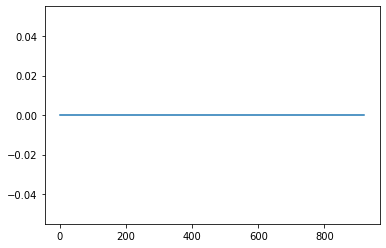

<Figure size 432x288 with 0 Axes>

In [189]:
correcto=0
sumVal=0
phone=0
start=0
stop=900
#y_actual=[1]*200+[1]*600+[1]*800
y_actual=[0]*200+[0]*800+[0]*800
for y in y_prediction:
    phone+=1
    correcto=0
    for x in range(start,stop):
        if y[x] == y_actual[x]:
            correcto+=1
    print("Single Phone",phone)
    print(correcto/(stop-start))
    sumVal+= correcto/(stop-start)
print("Average Value:", sumVal/len(y_prediction))
correcto=0
for x in range(start,stop):
    if predictedList[x] == y_actual[x]:
        correcto+=1
print("Accuracy for drone present:", correcto/(stop-start))
#plt.plot(np.arange(0,105,105/len(predictedList)),predictedList)
plt.plot(predictedList)
plt.figure()
print("Novel method outperforms by:", (100*((correcto/(stop-start))-sumVal/len(y_prediction))/abs(sumVal/len(y_prediction))), "%")
#plt.plot(classPrediction)